In [1]:
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# random forest classifier
from sklearn.ensemble import RandomForestClassifier

# split train and test set
from sklearn.model_selection import train_test_split

# upsamling (if needed)
from collections import Counter
from sklearn.datasets import make_classification
from imbens.sampler._over_sampling import SMOTE 
from imbens.sampler._over_sampling import ADASYN
from imbens.sampler._over_sampling import SVMSMOTE
from imbens.sampler._over_sampling import BorderlineSMOTE 
from imbens.sampler._over_sampling import RandomOverSampler 

# Overview
Construct basic random forest following https://www.kaggle.com/code/prashant111/random-forest-classifier-tutorial/notebook

Handle multicolinearity following https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

Calculate feature importance based on full model permutation importance:
https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance

# Compose dataset

In [2]:
# load dataset
pred2022 = pd.read_csv('pred2022.csv')
# pred2022.keys()

In [3]:
# test the effect of different 'high risk' definitions
# LATER COPY TO COMPILE DATASET1

# 1. Classified up: higher risk, else lower risk
uplisted1234 = ((pred2022['2004-2022 Genuine Change?'] == 'Genuine - uplisted') &
                (pred2022['2004 RL num'] != 5)).values * 1
not_downlisted5 = ((pred2022['2004-2022 Genuine Change?'] != 'Genuine - downlisted') &
                   (pred2022['2004 RL num'] == 5))

pred2022['higher risk'] = uplisted1234 + not_downlisted5

In [4]:
# drop non-numerical and unwanted columns
x = pred2022.drop(['Unnamed: 0', 'Family', 'Species Name', 'Species Name_x',
       '2004 GAA2 Red List Category', '2022 GAA2 Red List Category',
       '2022 Red List Criteria', '2004-2022 Genuine Change?',
       ' 2004-2022 Primary Driver', 'Grouped 2004-2022 Primary Driver',
       '2004-2022 Genuine downlisting due to conservation', '2022 RL num', 'Species Name_y', 'MAT_2022', 'AP_2022', 'Species'], axis=1)

# filter out highly corelated features (optional)
x = x.drop(['urbanareas_2021_change','MTWM_2022' ,'MTWM_change_2022','MTWM_nichefrac_2022' , 'MTCM_2022', 'MTCM_change_2022','MTCM_nichefrac_2022', 'PDQ_2022', 'PDQ_change_2022'], axis=1) 

# # filter out other low cardinality features (optional)
x = x.drop(['Egg Laying', 'Free Living Larval Stage', 'Live Birth ',
       'Water Breeding', 'Bd (ongoing)', 'Bsal (ongoing)', 'Invasive species'], axis=1)

# realms for later use: ['Afrotropical', 'Australasian/Oceanian', 'Indomalayan', 'Nearctic', 'Neotropical', 'Palearctic']

# drop nan values
x = x.dropna()

In [5]:
# only keep selected features
# X = X[['area_2021', 'N_realm', 'urbanareas_2021', 'rangeland_2021', 'managed_pasture_2021', 'MAT_nichefrac_2022', 'MAT_change_column_2022', 'AP_nichefrac_2022', 'AP_change_column_2022']]
# X = X.drop(['area_2021'], axis=1)

In [6]:
# x contains the key "Order" with three unique values. 
# create three subsets based on this key
order_keys = x['Order'].unique()

x_orders = {}
for i, ord in enumerate(order_keys):
    x_categories = {}
    for cat in range(1,7):
        x_categories[cat] = x[(x['Order'] == ord) & (x['2004 RL num'] == cat)].drop(['Order', '2004 RL num'], axis=1)
        print(f'Order: {ord}, Category: {cat}, Entries: {x_categories[cat].shape[0]}')
    x_orders[ord] = x_categories

Order: ANURA, Category: 1, Entries: 2502
Order: ANURA, Category: 2, Entries: 228
Order: ANURA, Category: 3, Entries: 477
Order: ANURA, Category: 4, Entries: 690
Order: ANURA, Category: 5, Entries: 330
Order: ANURA, Category: 6, Entries: 130
Order: CAUDATA, Category: 1, Entries: 184
Order: CAUDATA, Category: 2, Entries: 61
Order: CAUDATA, Category: 3, Entries: 74
Order: CAUDATA, Category: 4, Entries: 135
Order: CAUDATA, Category: 5, Entries: 79
Order: CAUDATA, Category: 6, Entries: 7
Order: GYMNOPHIONA, Category: 1, Entries: 66
Order: GYMNOPHIONA, Category: 2, Entries: 5
Order: GYMNOPHIONA, Category: 3, Entries: 4
Order: GYMNOPHIONA, Category: 4, Entries: 6
Order: GYMNOPHIONA, Category: 5, Entries: 3
Order: GYMNOPHIONA, Category: 6, Entries: 0


# Test splits (Order, Category)

In [7]:
# def updampling, downsampling 

def upsample(x, sm = SVMSMOTE(), test_size = 0.3):
    '''
    Split into train and test set and then upsample. 
    The order is important, otherwise the test split is not really independent and there is guaranteed overfitting. 
    
    Parameters:
    x: pandas dataframe
    sm: upsampling method
    test_size: test size
    
    Returns:
    X_train_ups, X_test_ups, y_train_ups, y_test_ups
    '''
    # split into target variable and feature vector
    y = x['higher risk']
    X = x.drop(['higher risk'], axis=1)
    
    # split train test 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
 
    # upsample
    try:
        X_train, y_train = sm.fit_resample(X_train, y_train)
        X_test, y_test = sm.fit_resample(X_test, y_test)
    except:
        try: 
            # SVMSMOTE requires six neighbours, if this does not work, use random oversampling
            # first for test set ...
            X_train, y_train = sm.fit_resample(X_train, y_train)
            sm = RandomOverSampler()
            X_test, y_test = sm.fit_resample(X_test, y_test)
        except:
            try: 
                # ... then for both
                sm = RandomOverSampler()
                X_train, y_train = sm.fit_resample(X_train, y_train)
                X_test, y_test = sm.fit_resample(X_test, y_test)
            except:
                # write none if upsampling fails
                X_train = np.array([None] * len(X_train))
                X_test = np.array([None] * len(X_test))
                y_train = np.array([None] * len(y_train))
                y_test = np.array([None] * len(y_test))
    
    
    return X_train, X_test, y_train, y_test

def downsample(x, test_size = 0.3):
    # split into target variable and feature vector
    y = x['higher risk']
    X = x.drop(['higher risk'], axis=1)
    
    # split train test 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    
    def downsampleXy(X, y):
        # find minority class
        minority_class = y.value_counts().idxmin()
        
        # get number of positive samples and total samples
        nmin = y.value_counts()[minority_class]
        ntot = y.shape[0]

        # get indices of negative samples
        maj_indices = y[y != minority_class].index

        # select (ntot - 2 * nmin) random sample from negative samples to kick out
        # np.random.seed(42)
        try:
            indices_to_kickout = np.random.choice(maj_indices, ntot - 2 * nmin, replace=False)

            # resample X and y based on indices
            X = X.drop(indices_to_kickout)
            y = y.drop(indices_to_kickout)
            
        except: 
            # write none if upsampling fails
            X = np.array([None] * len(X))
            y = np.array([None] * len(y)) 
            
        return X, y
    
    X_train, y_train = downsampleXy(X_train, y_train)
    X_test, y_test = downsampleXy(X_test, y_test)
    
    return X_train, X_test, y_train, y_test

def sample(x, test_size = 0.3):
    # split into target variable and feature vector
    y = x['higher risk']
    X = x.drop(['higher risk'], axis=1)
    
    # split train test 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    
    return X_train, X_test, y_train, y_test

In [8]:
# def trueskill score
from sklearn.metrics import confusion_matrix

# calculate TSS
def tss(y_test, y_pred, vocal=1):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensiticity = tp / (tp + fn)
    specitivity = tn / (fp + tn)
    tss = sensiticity + specitivity - 1

    if vocal == 2:
        print('Sensiticity (correctly positive): {0:0.4f}'. format(sensiticity))
        print('Specitivity (correctly negative): {0:0.4f}'. format(specitivity))
    if vocal in [1,2]:
        print('True Skill Score: {0:0.4f}'. format(tss))
        
    return tss
    

In [21]:
# create dataset splits

def get_dataset(x, sampling_function, split_type, cat_keys, vocal=0):
    
    if split_type == 'both':
        # split up the dataset for orders and categories
        splits = {'ANURA': {}, 'CAUDATA': {}, 'GYMNOPHIONA':{}}
        
        
        for ord in ['ANURA', 'CAUDATA', 'GYMNOPHIONA']:
            for cat in cat_keys:
                # get dataset for category
                xx = x[(x['Order'] == ord) & (x['2004 RL num'] == cat)].drop(['Order', '2004 RL num'], axis=1)
                
                X_train, X_test, y_train, y_test = sampling_function(xx)
                
                splits[ord][cat] = {
                    'X_train': X_train,
                    'X_test': X_test,
                    'y_train': y_train,
                    'y_test': y_test
                }
                
                if vocal == 1:
                    # if X_train contains None, print 'not enough data'
                    if None in X_train:
                        print(f'Order: {ord}, Category: {cat}, not enough data, positive samples in original dataset: {xx["higher risk"].sum()}')
                    else: 
                        print(f'Order: {ord}, Category: {cat}, train: {X_train.shape[0]}, test: {X_test.shape[0]}, positive samples in original dataset: {xx["higher risk"].sum()}')
            x_orders[ord] = x_categories
            
           
    if split_type == 'order':
        # split up the dataset for orders
        splits = {}
        for ord in ['ANURA', 'CAUDATA', 'GYMNOPHIONA']:
            xx = x[x['Order'] == ord].drop(['Order'], axis=1)
            X_train, X_test, y_train, y_test = sampling_function(xx)
            splits[ord] = {
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_test': y_test
            }
            
            if vocal == 1:
                # if X_train contains None, print 'not enough data'
                if None in X_train:
                    print(f'Order: {ord}, not enough data, positive samples in original dataset: {xx["higher risk"].sum()}')
                else: 
                    print(f'Order: {ord}, train: {X_train.shape[0]}, test: {X_test.shape[0]}, positive samples in original dataset: {xx["higher risk"].sum()}')
                    
    
    if split_type == 'category':
        splits = {}
        for cat in cat_keys:
            xx = x[x['2004 RL num'] == cat].drop(['2004 RL num'], axis=1)
            # convert order into numerical values
            order_dict = {'ANURA': 0, 'CAUDATA': 1, 'GYMNOPHIONA': 2}
            xx['Order'] = xx['Order'].map(order_dict)
            
            X_train, X_test, y_train, y_test = sampling_function(xx)
            splits[cat] = {
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_test': y_test
            }
            
            if vocal == 1:
                # if X_train contains None, print 'not enough data'
                if None in X_train:
                    print(f'Category: {cat}, not enough data, positive samples in original dataset: {xx["higher risk"].sum()}')
                else: 
                    print(f'Category: {cat}, train: {X_train.shape[0]}, test: {X_test.shape[0]}, positive samples in original dataset: {xx["higher risk"].sum()}')
                
    if split_type == 'none':
        # convert order into numerical values
        order_dict = {'ANURA': 0, 'CAUDATA': 1, 'GYMNOPHIONA': 2}
        xx = x.copy()
        xx['Order'] = xx['Order'].map(order_dict)
        
        X_train, X_test, y_train, y_test = sampling_function(xx)
        splits = {
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_test': y_test
            }
        
        if vocal == 1:
            print(f'Train: {X_train.shape[0]}, test: {X_test.shape[0]}, positive samples in original dataset: {x["higher risk"].sum()}')
            
    return splits

In [22]:
_ = get_dataset(x, upsample, 'both', [1,2,3,4,5], vocal=1)

Order: ANURA, Category: 1, train: 3398, test: 1052, positive samples in original dataset: 77
Order: ANURA, Category: 2, train: 239, test: 86, positive samples in original dataset: 28
Order: ANURA, Category: 3, train: 622, test: 284, positive samples in original dataset: 24
Order: ANURA, Category: 4, train: 934, test: 404, positive samples in original dataset: 21
Order: ANURA, Category: 5, train: 342, test: 163, positive samples in original dataset: 309
Order: CAUDATA, Category: 1, train: 232, test: 104, positive samples in original dataset: 16
Order: CAUDATA, Category: 2, train: 70, test: 28, positive samples in original dataset: 12
Order: CAUDATA, Category: 3, train: 94, test: 40, positive samples in original dataset: 7
Order: CAUDATA, Category: 4, not enough data, positive samples in original dataset: 3
Order: CAUDATA, Category: 5, train: 108, test: 46, positive samples in original dataset: 77
Order: GYMNOPHIONA, Category: 1, not enough data, positive samples in original dataset: 0
O

In [133]:
a.keys()

Index(['Order', 'Afrotropical', 'Australasian/Oceanian', 'Indomalayan',
       'Nearctic', 'Neotropical', 'Palearctic', 'N_realm', 'SemiAqua',
       'Generalist', 'Other', '2004 RL num', 'higher risk', 'urbanareas_2021',
       'cropland_2021', 'rangeland_2021', 'managed_pasture_2021',
       'cropland_2021_change', 'rangeland_2021_change',
       'managed_pasture_2021_change', 'area_2021', 'travel_time_2015',
       'population_density_2021', 'population_density_change_2021',
       'MAT_nichefrac_2022', 'MAT_change_2022', 'AP_nichefrac_2022',
       'AP_change_2022', 'PDQ_nichefrac_2022'],
      dtype='object')

In [118]:
# x = a[['Order', '2004 RL num', 'higher risk']]

In [23]:
# train random forest classifier

# define the keys for the dataset splits
n_iter = 100
cat_keys = [1,2,3,4,5]
order_keys = ['ANURA', 'CAUDATA', 'GYMNOPHIONA']
split_type = 'both' # 'order', 'category', 'both', 'none', 'none_catbalanced'
# create a function handle for the sampling function
sampling_function = upsample # upsample, downsample, sample


if split_type == 'both': 
    
    true_skill_scores = np.zeros((n_iter,len(order_keys), len(cat_keys)))
    
    for n in range(n_iter):
        if n % 10 == 0:
            print(f'Iteration: {n}')
        
        # create new dataset
        splits = get_dataset(x, sampling_function, split_type, cat_keys)
        
        for i, key in enumerate(order_keys):
            for j, cat in enumerate(cat_keys):

                rfc = RandomForestClassifier(n_estimators=10, max_features= 14, min_samples_leaf=5,
                                    min_impurity_decrease= 0.0002, random_state=42)

                try:
                    # Fit the model
                    rfc.fit(splits[key][cat]['X_train'].drop(['Order', '2004 RL num'], axis=1),
                            splits[key][cat]['y_train'])

                    # Predict the Test set results
                    y_pred = rfc.predict(splits[key][cat]['X_test'].drop(['Order', '2004 RL num'], axis=1))

                    # Check the performance of the model
                    # print(f'Order: {key}, Category: {cat}')
                    true_skill_scores[n,i,j] = tss(splits[key][cat]['y_test'], y_pred, vocal=0)
                except:
                    true_skill_scores[n,i,j] = np.nan
if split_type == 'order':
    
    true_skill_scores = np.zeros((n_iter,len(order_keys)))
    
    for n in range(n_iter):
        if n % 10 == 0:
            print(f'Iteration: {n}')
        
        # create new dataset
        splits = get_dataset(x, sampling_function, split_type, cat_keys)
        
        for i, key in enumerate(order_keys):
            rfc = RandomForestClassifier(n_estimators=10, max_features= 14, min_samples_leaf=5,
                                min_impurity_decrease= 0.0002, random_state=42)

            try:
            # Fit the model
                rfc.fit(splits[key]['X_train'], splits[key]['y_train'])
            

                # Predict the Test set results
                y_pred = rfc.predict(splits[key]['X_test'])

                # Check the performance of the model
                # print(f'Order: {key}')
                true_skill_scores[n,i] =  tss(splits[key]['y_test'], y_pred, vocal=0)
                
            except: 
                true_skill_scores[n,i] = np.nan
        
if split_type == 'category':
    
    true_skill_scores = np.zeros((n_iter,len(cat_keys)))
    
    for n in range(n_iter):
        if n % 10 == 0:
            print(f'Iteration: {n}')
            
        # create new dataset
        splits = get_dataset(x, sampling_function, split_type, cat_keys)
        
        for j, cat in enumerate(cat_keys):
            rfc = RandomForestClassifier(n_estimators=10, max_features= 14, min_samples_leaf=5,
                                min_impurity_decrease= 0.0002, random_state=42)

            # Fit the model
            rfc.fit(splits[cat]['X_train'], splits[cat]['y_train'])

            # Predict the Test set results
            y_pred = rfc.predict(splits[cat]['X_test'])

            # Check the performance of the model
            # print(f'Category: {cat}')
            true_skill_scores[n,j] = tss(splits[cat]['y_test'], y_pred, vocal=0)
        
if split_type == 'none':
    
    true_skill_scores = np.zeros(n_iter)
    
    for n in range(n_iter):
        if n % 10 == 0:
            print(f'Iteration: {n}')
            
        # create new dataset
        splits = get_dataset(x, sampling_function, split_type, cat_keys)
        
        rfc = RandomForestClassifier(n_estimators=10, max_features= 14, min_samples_leaf=5,
                            min_impurity_decrease= 0.0002, random_state=42)

        # Fit the model
        rfc.fit(splits['X_train'], splits['y_train'])

        # Predict the Test set results
        y_pred = rfc.predict(splits['X_test'])

        # Check the performance of the model
        true_skill_scores[n] = tss(splits['y_test'], y_pred, vocal=1)
        
if split_type == 'none_catbalanced':
    
    true_skill_scores = np.zeros(n_iter)
    
    for n in range(n_iter):
        if n % 10 == 0:
            print(f'Iteration: {n}')
            
        # create new dataset
        dat = get_dataset(x, sampling_function, 'category', [1,2,3,4,5])
        splits = {
            'X_train': pd.concat([dat[1]['X_train'], dat[2]['X_train'], dat[3]['X_train'], dat[4]['X_train'], dat[5]['X_train']]),
            'y_train': pd.concat([dat[1]['y_train'], dat[2]['y_train'], dat[3]['y_train'], dat[4]['y_train'], dat[5]['y_train']]),
            'X_test': pd.concat([dat[1]['X_test'], dat[2]['X_test'], dat[3]['X_test'], dat[4]['X_test'], dat[5]['X_test']]),
            'y_test': pd.concat([dat[1]['y_test'], dat[2]['y_test'], dat[3]['y_test'], dat[4]['y_test'], dat[5]['y_test']])
        }
        
        rfc = RandomForestClassifier(n_estimators=10, max_features= 14, min_samples_leaf=5,
                            min_impurity_decrease= 0.0002, random_state=42)

        # Fit the model
        rfc.fit(splits['X_train'], splits['y_train'])

        # Predict the Test set results
        y_pred = rfc.predict(splits['X_test'])

        # Check the performance of the model
        true_skill_scores[n] = tss(splits['y_test'], y_pred, vocal=0)

Iteration: 0
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90


In [26]:
print(f'True Skill Score: {np.round(true_skill_scores.mean(axis=0),2)} +/- {np.round(true_skill_scores.std(axis=0),2)}')

AxisError: axis 0 is out of bounds for array of dimension 0

# Choose one
Since we get the best TSS score for the whole dataset with upsampling, we can now train a model on this data and vizualize it in different ways!


In [27]:
# convert order into numerical values
order_dict = {'ANURA': 0, 'CAUDATA': 1, 'GYMNOPHIONA': 2}
xx = x.copy()
xx['Order'] = xx['Order'].map(order_dict)

# drop area, RL num
xx = xx.drop(['area_2021', '2004 RL num'], axis=1)

# xx = xx[['Order', 'Afrotropical', 'Australasian/Oceanian', 'Indomalayan',
#        'Nearctic', 'Neotropical', 'Palearctic', 'N_realm', 'SemiAqua',
#        'Generalist', 'Other', '2004 RL num', 'higher risk']]

# split into target variable and feature vector
y = xx['higher risk']
X = xx.drop(['higher risk'], axis=1)
    
# split train test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=20)

# upsample
sm = SVMSMOTE(random_state=20)
X_train, y_train = sm.fit_resample(X_train, y_train)
X_test, y_test = sm.fit_resample(X_test, y_test)

# initialize RF        
rfc = RandomForestClassifier(n_estimators=100, max_features= 14, min_samples_leaf=5,
                    min_impurity_decrease= 0.0002, random_state=20)

# Fit the model
rfc.fit(X_train, y_train)

# Predict the Test set results
y_pred = rfc.predict(X_test)

# Check the performance of the model
true_skill_scores = tss(y_test, y_pred, vocal=2)

Sensiticity (correctly positive): 0.7790
Specitivity (correctly negative): 0.9610
True Skill Score: 0.7401


In [28]:
from sklearn.inspection import permutation_importance


def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=2)
    perm_sorted_idx = result.importances_mean.argsort()[::-1]
    # forest_importances = pd.Series(result.importances_mean, index=X_train.columns).sort_values(ascending=False)

    # make x axis log scale
    sns.barplot(
        x = result.importances_mean[perm_sorted_idx].T,
        xerr = result.importances_std[perm_sorted_idx].T,
        y = X.columns[perm_sorted_idx]
    )
    
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

True Skill Score: 0.7401


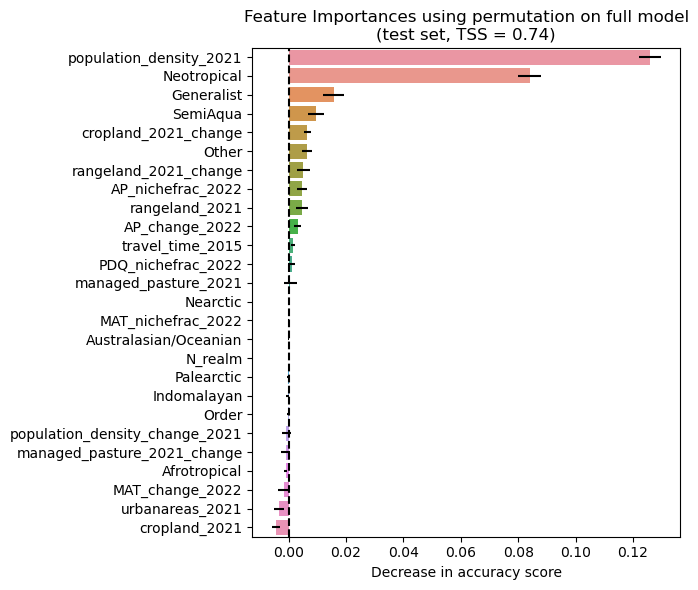

In [29]:
fig, ax = plt.subplots(figsize=(7, 6))
plot_permutation_importance(rfc, X_test, y_test, ax)
ax.set_title("Feature Importances using permutation on full model\n(test set, TSS = {})".format(np.round(tss(y_test, y_pred), 2)))
ax.set_xlabel("Decrease in accuracy score")
_ = ax.figure.tight_layout()

## Handle multicollinear features
Following [skikit learn documentation](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py)

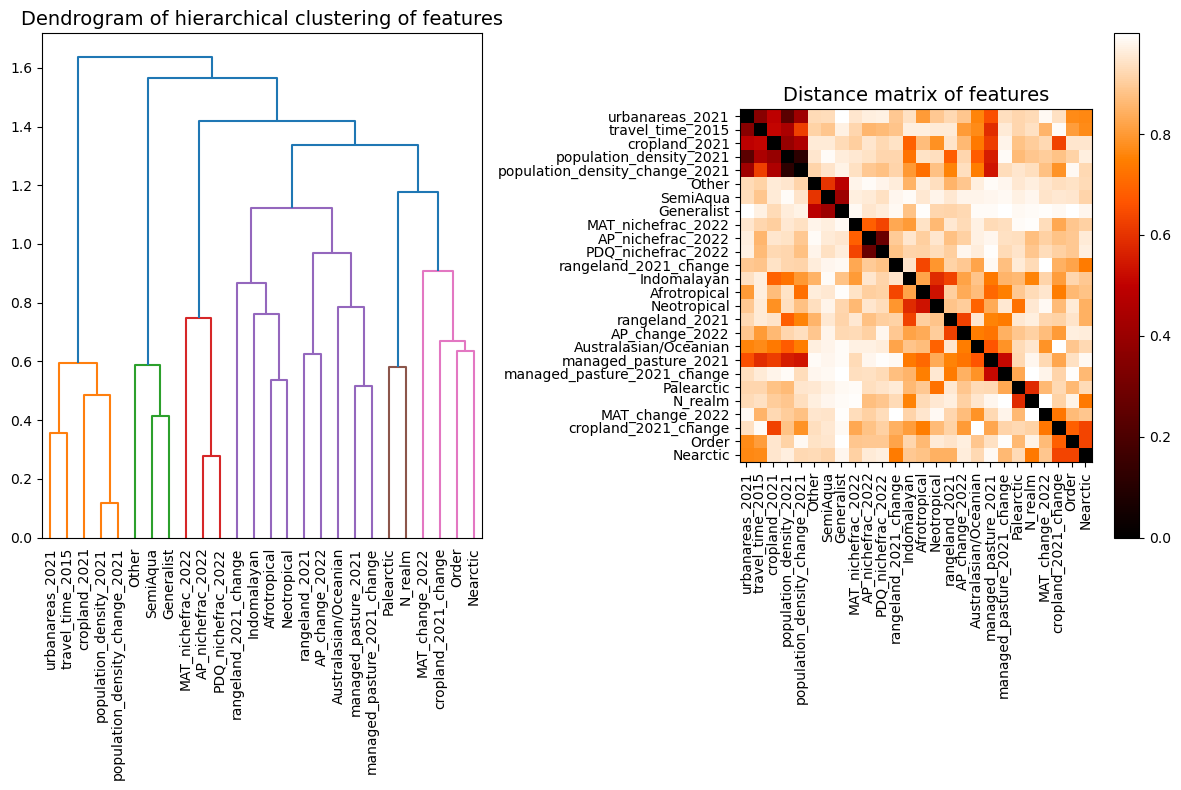

In [34]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

# X = X_test_ups
# y = y_test_ups


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))
ax1.set_title("Dendrogram of hierarchical clustering of features", fontsize=14)

ax2.imshow(distance_matrix[dendro["leaves"], :][:, dendro["leaves"]])
# add colorbar with cmap='gist_heat_r'
cbar = plt.colorbar(ax2.imshow(distance_matrix[dendro["leaves"], :][:, dendro["leaves"]], cmap='gist_heat'), ax=ax2)
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
ax2.set_title("Distance matrix of features", fontsize=14)
_ = fig.tight_layout()

**Hirarchical clustering** \
(see [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage))


**Hirarchical dendogram (left)** \
The top of the U-link indicates a cluster merge. The two legs of the U-link indicate which clusters were merged. The length of the two legs of the U-link represents the distance between the child clusters. It is also the cophenetic distance between original observations in the two children clusters.



### Calculating new RF and feature importances on balanced dataset

In [35]:
'N_realm', 'urbanareas_2021', 'rangeland_2021', 'area_2021'

('N_realm', 'urbanareas_2021', 'rangeland_2021', 'area_2021')

In [37]:
from collections import defaultdict

cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
# for each cluster, select the feature with the highest permutation importance in the full model

    
# selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features_names = X.columns[selected_features]

# select other features!
# selected_features_names = ['2004 RL num', 'N_realm', 'AP_nichefrac_2022', 'AP_change_2022', 'urbanareas_2021', 'rangeland_2021', 'area_2021']

X_train_sel = X_train[selected_features_names]
X_test_sel = X_test[selected_features_names]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print(
    "Baseline accuracy on test data with features removed:"
    f" {clf_sel.score(X_test_sel, y_test):.2}"
)
print()
_ = tss(y_test, clf_sel.predict(X_test_sel), vocal=True)

Baseline accuracy on test data with features removed: 0.77

True Skill Score: 0.5371


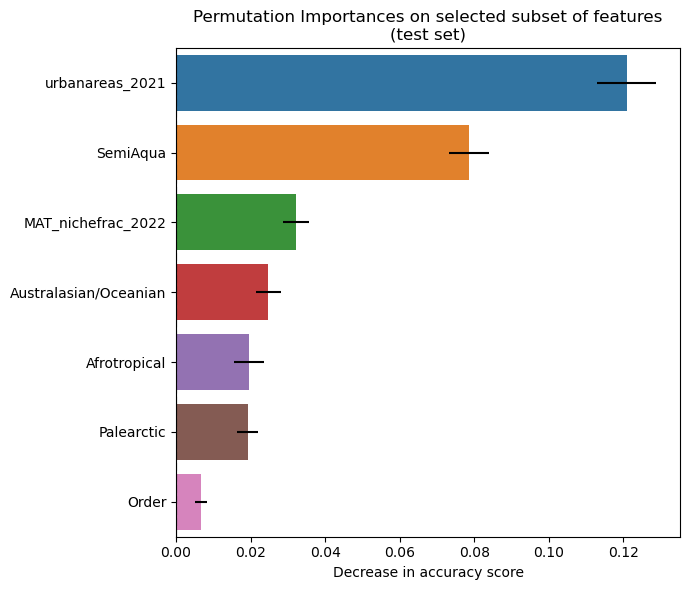

In [39]:
fig, ax = plt.subplots(figsize=(7, 6))
plot_permutation_importance(clf_sel, X_test_sel, y_test, ax)
ax.set_title("Permutation Importances on selected subset of features\n(test set)")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
plt.show()

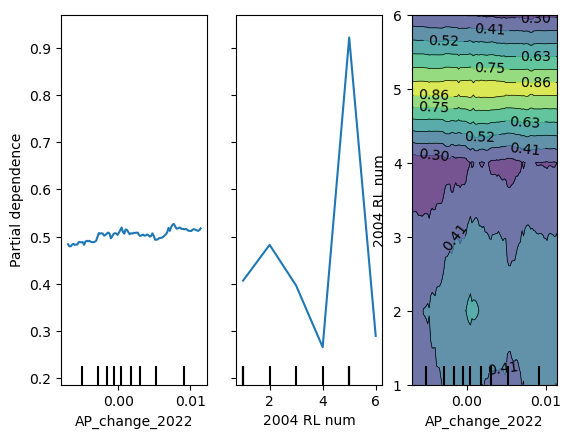

In [67]:
# partial dependence plot 
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
# fig = plt.figure(figsize=(5, 15))
features = [3, 0, (3, 0)]
PartialDependenceDisplay.from_estimator(clf_sel, X_train_sel, features)

In [27]:
# # Tree Visualisation
# from sklearn import tree
# fn=X_train.columns
# cn=X_train.columns
# fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (16,16), dpi=1600)
# tree.plot_tree(rfc.estimators_[0],
#             #    filled = True)

[Text(0.564453125, 0.9642857142857143, 'x[8] <= 13510.612\ngini = 0.5\nsamples = 742\nvalue = [574, 588]'),
 Text(0.32003348214285715, 0.8928571428571429, 'x[8] <= 7549.22\ngini = 0.367\nsamples = 391\nvalue = [152, 477]'),
 Text(0.18973214285714285, 0.8214285714285714, 'x[12] <= 0.02\ngini = 0.281\nsamples = 290\nvalue = [79, 388]'),
 Text(0.18080357142857142, 0.75, 'x[10] <= 0.903\ngini = 0.267\nsamples = 287\nvalue = [73, 388]'),
 Text(0.13839285714285715, 0.6785714285714286, 'x[7] <= 0.004\ngini = 0.222\nsamples = 254\nvalue = [51, 351]'),
 Text(0.09375, 0.6071428571428571, 'x[1] <= 0.14\ngini = 0.167\nsamples = 187\nvalue = [27, 267]'),
 Text(0.07142857142857142, 0.5357142857142857, 'x[8] <= 5988.56\ngini = 0.148\nsamples = 181\nvalue = [23, 262]'),
 Text(0.05357142857142857, 0.4642857142857143, 'x[3] <= 0.002\ngini = 0.088\nsamples = 138\nvalue = [10, 207]'),
 Text(0.044642857142857144, 0.39285714285714285, 'x[6] <= 0.0\ngini = 0.167\nsamples = 73\nvalue = [10, 99]'),
 Text(0.035

C:\Users\Claus\AppData\Local\Temp\ipykernel_10844\4105356910.py:44: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\Claus\AppData\Local\Temp\ipykernel_10844\4105356910.py:44: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\Claus\AppData\Local\Temp\ipykernel_10844\4105356910.py:44: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\Claus\AppData\Local\Temp\ipykernel_10844\4105356910.py:44: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\Claus\AppData\Local\Temp\ipykernel_10844\4105356910.py:44: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\Claus\AppData\Local\Temp\ipykernel_10844\4105356910.py:44: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap

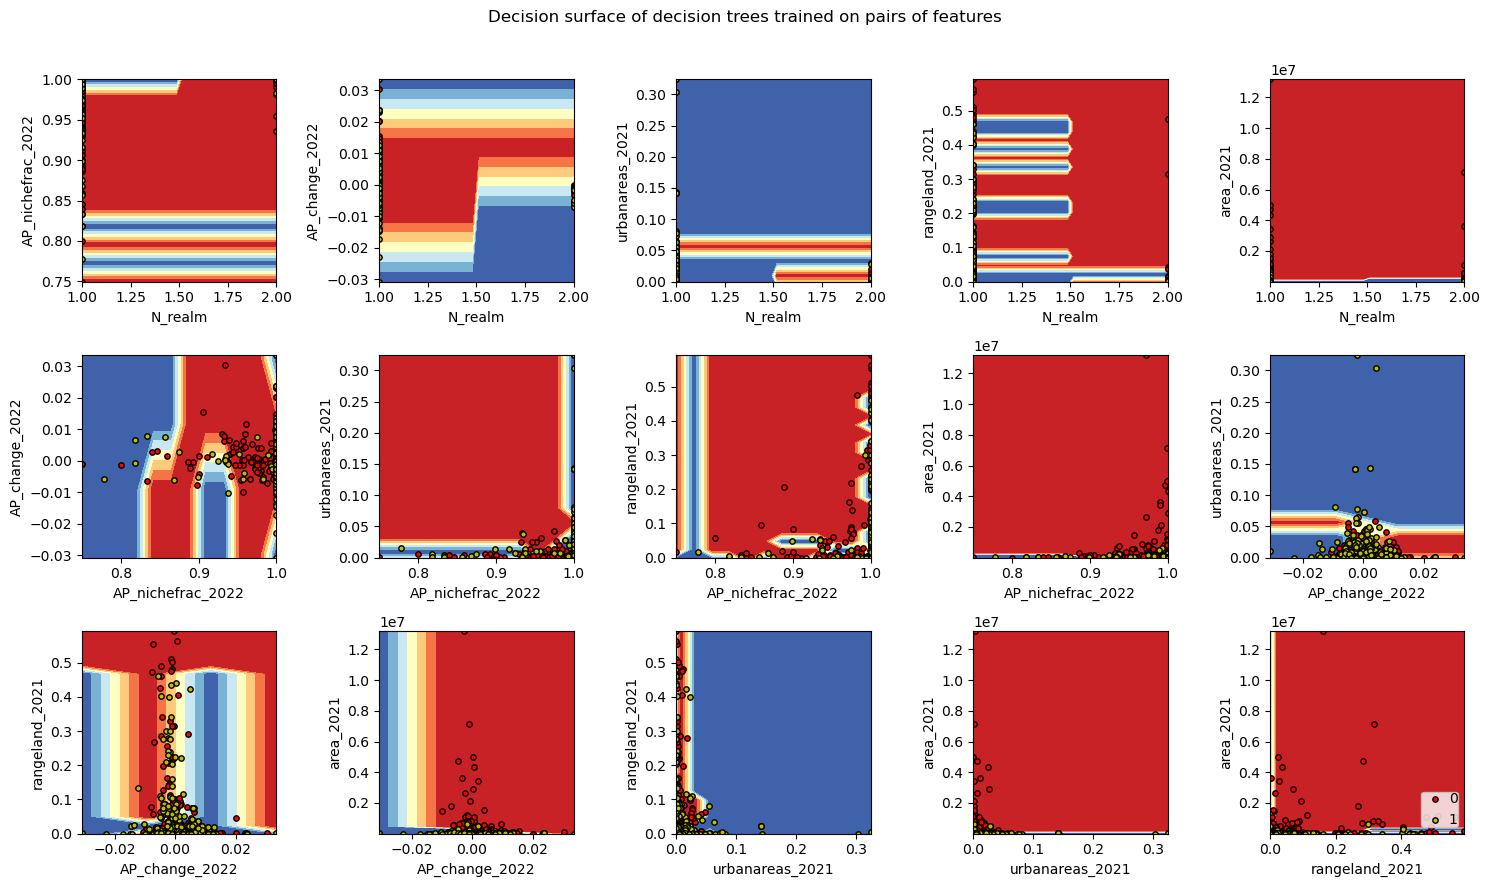

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = len(np.unique(y_test_ups))
plot_colors = "ryb"
plot_step = 0.02

# Convert pandas DataFrame to numpy array
X_test_sel_np = X_test_sel.to_numpy()
y_test_ups_np = y_test_ups.to_numpy()

# Get feature pairs
feature_pairs = [[i, j] for i in range(X_test_sel_np.shape[1]) for j in range(i+1, X_test_sel_np.shape[1])]

# Set the figsize for the whole plot
fig, axs = plt.subplots(3, 5, figsize=(15, 9))

for pairidx, pair in enumerate(feature_pairs):
    # We only take the two corresponding features
    X = X_test_sel_np[:, pair]
    y = y_test_ups_np

    # Train
    clf = DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    ax = axs.flatten()[pairidx]  # Access the correct subplot
    display = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        cmap=plt.cm.RdYlBu,
        response_method="predict",
        ax=ax,
        xlabel=X_test_sel.columns[pair[0]],
        ylabel=X_test_sel.columns[pair[1]],
    )
    
    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        ax.scatter(
            X[idx, 0],
            X[idx, 1],
            c=color,
            label=i,
            cmap=plt.cm.RdYlBu,
            edgecolor="black",
            s=15,
        )
    
    # Set x and y limits based on the training points
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    ax.set_xlim(max(xlim[0], x_min), min(xlim[1], x_max))
    ax.set_ylim(max(ylim[0], y_min), min(ylim[1], y_max))

fig.suptitle("Decision surface of decision trees trained on pairs of features")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout, leaving space for the title
plt.show()
